In [1]:
import os
import pickle
import numpy as np
from sys import path

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from ndcube import NDCube, NDCubeSequence, NDCollection

import astropy.units as u
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # Make the fonts in figures big enough for papers
plt.rcParams.update({'figure.figsize':[24,16]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=128)

base_path = "./"
emtk_path = base_path+'code/'
path.append(emtk_path)
import EMToolKit.EMToolKit as emtk
from EMToolKit.instruments.aia import load_from_paths
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper

In [2]:
# Example data to load. We'll use a part of the field of view observed by the Hi-C rocket in 2012.
date='2012/07/11 18:54:00'
xlen = 512*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
ylen = 512*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
xl = -300*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
yl = -425*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

sdo_data_dir = base_path+"data/" # Place to put data files.
pathsname = sdo_data_dir+"paths.p"
reload = False

if(os.path.exists(pathsname) == False or reload):
    paths = []
    passbands = np.array([94,131,171,193,211,335])*u.angstrom
    for band in passbands: 
        qry = Fido.search(a.Time(TimeRange(date,12*u.s)),a.Instrument('AIA'),a.Wavelength(band))[0,0]
        paths.append(Fido.fetch(qry,path=sdo_data_dir))
    pickle.dump(paths, open(sdo_data_dir+"paths.p", "wb"))
else: paths = pickle.load(open(pathsname, "rb" ) )

In [3]:
[maps,errs,logts,tresps] = load_from_paths(paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
datasequence = emtk.em_data(maps,errs,logts,tresps)

In [4]:
em_collection = emtk.em_collection(datasequence)

In [5]:
coeffs,logts,bases,wcs,algorithm = simple_reg_dem_wrapper(em_collection.data())

In [6]:
demsequence = emtk.dem_model(coeffs,logts,bases,wcs,algorithm,simple_reg_dem_wrapper)
em_collection.add_model(demsequence)

Text(0.5, 1.0, 'DEM at Log_10(T) = 6.75')

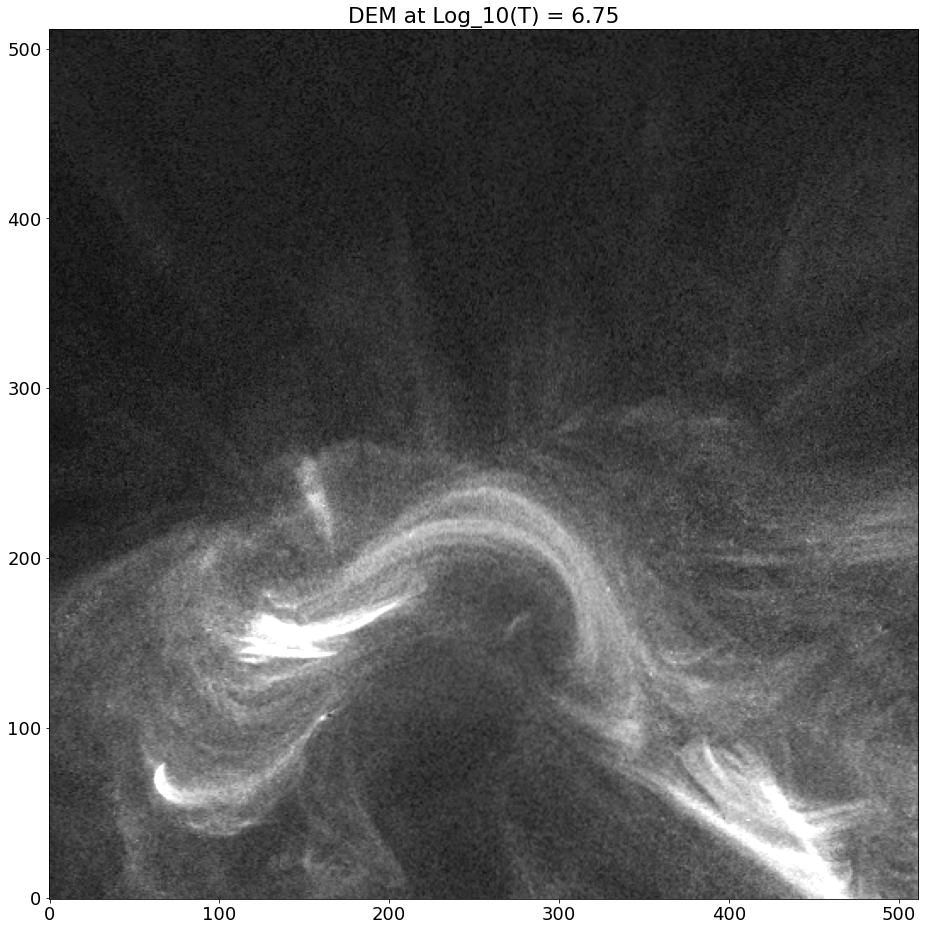

In [7]:
demmax = 5.0e28
gfac = 1.0/2.2
tempindex = 25
plt.imshow(demsequence[tempindex,:,:].data**gfac,vmin=0,vmax=demmax**gfac,cmap=plt.get_cmap('gray'))
plt.title('DEM at Log_10(T) = '+str(demsequence[tempindex].meta['logt0']))